<a href="https://colab.research.google.com/github/hugobbi/mnist-visual-fields/blob/main/mnist_visual_fields.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Load MNIST dataset - Using SKLEARN

In [ ]:
#
# It is possible to load mnist using sklearn
# mnist = fetch_openml('mnist_784',version=1)
# mnist.keys()
# X,y = mnist["data"], mnist["target"]
# The API of fetch_openml changed between versions. In earlier versions, it returns a numpy.ndarray array.
# Since 0.24.0 (December 2020), as_frame argument of fetch_openml is set to auto (instead of False as default
# option earlier) which gives you a pandas.DataFrame for the MNIST data.
# You can force the data read as a numpy.ndarray by setting as_frame = False. See fetch_openml reference .
# My solution was simply to turn the dataframe in an array
# Xnp = X.to_numpy()
# I opt by using keras to upload the dataset

Load MNIST dataset - Using KERAS

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
dataset_mnist = keras.datasets.mnist
(X_train_full,y_train_full),(X_test,y_test) = dataset_mnist.load_data()
X_train_full = X_train_full/255.0
X_test = X_test/255.0


11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
X_train_full[2].max()

1.0

In [ ]:
# NEW
def Shuffle_Two_Visual_Fields_Dataset(Xdata_left, Xdata_right,ydata):
  # Shuffle of the dataset
  i = np.random.permutation(ydata.shape[0])
  Xdata_left_new  = np.take(Xdata_left, i,axis=0)
  Xdata_right_new = np.take(Xdata_right,i,axis=0)
  ydata_new       = np.take(ydata,      i,axis=0)
  return Xdata_left_new,Xdata_right_new,ydata

In [ ]:
# NEW
def Double_and_Shuffle_Dataset(Xdata,ydata):
  # First shuffle of the dataset
  i1 = np.random.permutation(Xdata.shape[0])
  Xdata1 = np.take(Xdata,i1,axis=0)
  ydata1 = np.take(ydata,i1,axis=0)
  # Second shuffle of the dataset
  i2 = np.random.permutation(Xdata.shape[0])
  Xdata2 = np.take(Xdata,i2,axis=0)
  ydata2 = np.take(ydata,i2,axis=0)
  # Concatenating the two shuffles
  Xdata_SD = np.concatenate((Xdata1,Xdata2),axis=0)
  ydata_SD = np.concatenate((ydata1,ydata2),axis=0)
  return Xdata_SD,ydata_SD

In [ ]:
# NEW
def Build_Visual_Field_Set_With_Attention(XdataL,ydataL,XdataR,ydataR,full_att,reduc_att):
  N = XdataL.shape[0]         # the size of the datasets
  XdataL_new = XdataL.copy()  # deep copy to avoid in place changes
  XdataR_new = XdataR.copy()  # deep copy to avoid in place changes
  ydata_new  = np.zeros(N)    # the answer considering the attention
  randn = np.random.binomial(1,0.5 , size=N)
  for i in range(N):
    if(randn[i] == 1):
      # the attented visual field is the left
      ydata_new[i] = ydataL[i]
      # the right visual field has reduced attention
      XdataR_new[i] = reduc_att*XdataR[i]
      XdataL_new[i] =  full_att*XdataL[i]
    else:
      # the attented visual field is the right
      ydata_new[i] = ydataR[i]
      # the left visual field has reduced attention
      XdataR_new[i] =  full_att*XdataR[i]
      XdataL_new[i] = reduc_att*XdataL[i]
  return XdataL_new,XdataR_new,ydata_new

In [ ]:
def See_Visual_Field_Set(Xdata_L,Xdata_R,ydata,Num):
  fig1, ax = plt.subplots(Num, 2,figsize=(2.4, Num*1.2))
  maxi = np.zeros(Num)
  for i in range(Num):
    maxi[i] = 1 #max(Xdata_L[i].max(),Xdata_R[i].max())
    ax[i,0].imshow(Xdata_L[i],cmap="binary",vmax=maxi[i])
    ax[i,1].imshow(Xdata_R[i],cmap="binary",vmax=maxi[i])
    ax[i,1].text(45,18,'%d'%(ydata[i]),fontsize=20)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
  plt.show()

In [ ]:
# Creating training sets for the Left and Right Visual Field
# The competitive sitimulus (CS) dataset. Size equals to 2x the original size
X_L, y_L = Double_and_Shuffle_Dataset(X_train_full,y_train_full)
X_R, y_R = Double_and_Shuffle_Dataset(X_train_full,y_train_full)
Xtrain_L_new,Xtrain_R_new,y_train_new = Build_Visual_Field_Set_With_Attention(X_L,y_L,X_R,y_R, full_att=1.0,reduc_att=0.5 )
# The dataset with a single stimulus (SS) in only one of the visual fields. Size equals to 2x the original MNIST size
X_L, y_L = Double_and_Shuffle_Dataset(X_train_full,y_train_full)
X_R, y_R = Double_and_Shuffle_Dataset(X_train_full,y_train_full)
Xtrain_L_snew,Xtrain_R_snew,y_train_snew = Build_Visual_Field_Set_With_Attention(X_L,y_L,X_R,y_R, full_att=0.5,reduc_att=0.0 )
# Join both datasets with CS before SS. Size equals to 4x the original MNIST size
Xtrain_Left  = np.concatenate((Xtrain_L_new,Xtrain_L_snew),axis=0)
Xtrain_Right = np.concatenate((Xtrain_R_new,Xtrain_R_snew),axis=0)
ytrain_final = np.concatenate((y_train_new,y_train_snew),axis=0)
del Xtrain_L_new,Xtrain_R_new,y_train_new,Xtrain_L_snew,Xtrain_R_snew,y_train_snew,X_L,y_L,X_R,y_R
# Suffle the datasets so the elements of CS and SS are randomly ordered.
i = np.random.permutation(ytrain_final.shape[0])
Xtrain_Left  = np.take(Xtrain_Left, i,axis=0)
Xtrain_Right = np.take(Xtrain_Right,i,axis=0)
ytrain_final = np.take(ytrain_final,i,axis=0)

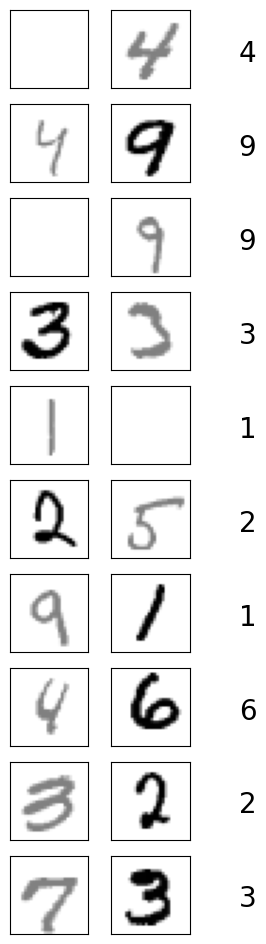

In [ ]:
See_Visual_Field_Set(Xtrain_Left,Xtrain_Right,ytrain_final,10)

In [ ]:
# Creating test sets for the Left and Right Visual Field
# The competitive sitimulus (CS) dataset. Size equals to 2x the original size
X_L, y_L = Double_and_Shuffle_Dataset(X_test,y_test)
X_R, y_R = Double_and_Shuffle_Dataset(X_test,y_test)
Xtest_L_new, Xtest_R_new, y_test_new  = Build_Visual_Field_Set_With_Attention(X_L,y_L,X_R,y_R, full_att=1.0,reduc_att=0.5 )
# The dataset with a single stimulus (SS) in only one of the visual fields. Size equals to 2x the original MNIST size
X_L, y_L = Double_and_Shuffle_Dataset(X_test,y_test)
X_R, y_R = Double_and_Shuffle_Dataset(X_test,y_test)
Xtest_L_snew,Xtest_R_snew,y_test_snew = Build_Visual_Field_Set_With_Attention(X_L,y_L,X_R,y_R, full_att=0.5,reduc_att=0.0 )
# Join both datasets with CS before SS. Size equals to 4x the original MNIST size
Xtest_Left  = np.concatenate((Xtest_L_new,Xtest_L_snew),axis=0)
Xtest_Right = np.concatenate((Xtest_R_new,Xtest_R_snew),axis=0)
ytest_final = np.concatenate((y_test_new,y_test_snew),axis=0)
del Xtest_L_new,Xtest_R_new,y_test_new,Xtest_L_snew,Xtest_R_snew,y_test_snew,X_L,y_L,X_R,y_R
# Suffle the datasets so the elements of CS and SS are randomly ordered.
i = np.random.permutation(ytest_final.shape[0])
Xtest_Left  = np.take(Xtest_Left, i,axis=0)
Xtest_Right = np.take(Xtest_Right,i,axis=0)
ytest_final = np.take(ytest_final,i,axis=0)

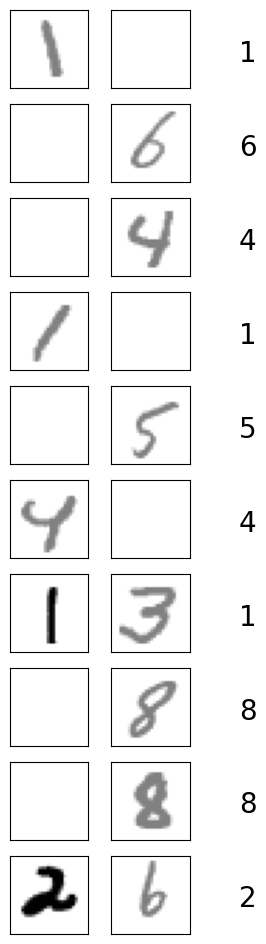

In [ ]:
See_Visual_Field_Set(Xtest_Left,Xtest_Right,ytest_final,10)

## THE SIMPLE MNIST MODEL

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300,activation="relu"))
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Dense(100,activation="relu"))
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Dense(10,activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 300)               235500    
                                                                 
 dropout_7 (Dropout)         (None, 300)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               30100     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trai

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

In [ ]:
history = model.fit(X_train_full, y_train_full, epochs=50, validation_data=(X_test,y_test))

Epoch 1/50
1875/1875 [==============================] - 9s 4ms/step - loss: 0.8668 - accuracy: 0.7280 - val_loss: 0.3246 - val_accuracy: 0.9098
Epoch 2/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4321 - accuracy: 0.8705 - val_loss: 0.2465 - val_accuracy: 0.9288
Epoch 3/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3457 - accuracy: 0.8993 - val_loss: 0.2071 - val_accuracy: 0.9393
Epoch 4/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2977 - accuracy: 0.9148 - val_loss: 0.1822 - val_accuracy: 0.9443
Epoch 5/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2666 - accuracy: 0.9217 - val_loss: 0.1633 - val_accuracy: 0.9510
Epoch 6/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2395 - accuracy: 0.9303 - val_loss: 0.1479 - val_accuracy: 0.9562
Epoch 7/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2178 - accuracy: 0.9367 - val_loss: 0.1375 - val_accuracy

##  NETWORK WITH TWO VISUAL FIELDS:
FUSION (CONCATENATION) AFTER THE SECOND LAYER

In [ ]:
input_L    = keras.layers.Input(shape=[28,28], name="left_input")
flatten_L  = keras.layers.Flatten()(input_L)
hidden1_L  = keras.layers.Dense(300,activation="relu")(flatten_L)
drop1_L    = keras.layers.Dropout(rate=0.4)(hidden1_L)
hidden2_L  = keras.layers.Dense(100,activation="relu")(drop1_L)
drop2_L    = keras.layers.Dropout(rate=0.4)(hidden2_L)

input_R    = keras.layers.Input(shape=[28,28], name="right_input")
flatten_R  = keras.layers.Flatten()(input_R)
hidden1_R  = keras.layers.Dense(300,activation="relu")(flatten_R)
drop1_R    = keras.layers.Dropout(rate=0.4)(hidden1_R)
hidden2_R  = keras.layers.Dense(100,activation="relu")(drop1_R)
drop2_R    = keras.layers.Dropout(rate=0.4)(hidden2_R)

concat_LR     = keras.layers.concatenate([drop2_L,drop2_R])
output_LR     = keras.layers.Dense(10,activation="softmax")(concat_LR)

model_LR_FH2    = keras.Model(inputs=[input_L,input_R],outputs=[output_LR] )

In [ ]:
model_LR_FH2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 28, 28)]     0           []                               
                                                                                                  
 right_input (InputLayer)       [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten (Flatten)              (None, 784)          0           ['left_input[0][0]']             
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['right_input[0][0]']            
                                                                                              

In [ ]:
model_LR_FH2.compile(loss="sparse_categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

In [ ]:
#history_LR_FH2 = model_LR_FH2.fit((Xtrain_L_new,Xtrain_R_new), y_train_new, epochs=20, validation_data=((Xtest_L_new,Xtest_R_new),y_test_new))

In [ ]:
# Training set  (Xtrain_Left,Xtrain_Right), ytrain_final
sizeTr = ytrain_final.shape[0]
newsizeTr = int(sizeTr/1)
XTr_L  = Xtrain_Left [:newsizeTr]
XTr_R  = Xtrain_Right[:newsizeTr]
yTr    = ytrain_final[:newsizeTr]
# Test set      (Xtest_Left, Xtest_Right), ytest_final
sizeTe = ytest_final.shape[0]
newsizeTe = int(sizeTe/1)
XTe_L  = Xtest_Left [:newsizeTe]
XTe_R  = Xtest_Right[:newsizeTe]
yTe    = ytest_final[:newsizeTe]
history_LR_FH2 = model_LR_FH2.fit((XTr_L,XTr_R),yTr, epochs=50, validation_data=((XTe_L,XTe_R),yTe))

Epoch 1/50
7500/7500 [==============================] - 57s 7ms/step - loss: 1.0302 - accuracy: 0.6983 - val_loss: 0.4783 - val_accuracy: 0.8811
Epoch 2/50
7500/7500 [==============================] - 56s 7ms/step - loss: 0.5965 - accuracy: 0.8422 - val_loss: 0.3614 - val_accuracy: 0.9103
Epoch 3/50
7500/7500 [==============================] - 54s 7ms/step - loss: 0.4878 - accuracy: 0.8756 - val_loss: 0.3011 - val_accuracy: 0.9243
Epoch 4/50
7500/7500 [==============================] - 53s 7ms/step - loss: 0.4243 - accuracy: 0.8943 - val_loss: 0.2624 - val_accuracy: 0.9365
Epoch 5/50
7500/7500 [==============================] - 55s 7ms/step - loss: 0.3780 - accuracy: 0.9068 - val_loss: 0.2392 - val_accuracy: 0.9419
Epoch 6/50
7500/7500 [==============================] - 55s 7ms/step - loss: 0.3482 - accuracy: 0.9148 - val_loss: 0.2151 - val_accuracy: 0.9482
Epoch 7/50
7500/7500 [==============================] - 56s 8ms/step - loss: 0.3161 - accuracy: 0.9241 - val_loss: 0.1976 - val_ac

## NETWORK WITH TWO VISUAL FIELDS:
 FUSION (CONCATENATION) AFTER THE FIRST HIDDEN LAYER

In [ ]:
input_L    = keras.layers.Input(shape=[28,28], name="left_input")
flatten_L  = keras.layers.Flatten()(input_L)
hidden1_L  = keras.layers.Dense(300,activation="relu")(flatten_L)
drop1_L    = keras.layers.Dropout(rate=0.4)(hidden1_L)

input_R    = keras.layers.Input(shape=[28,28], name="right_input")
flatten_R  = keras.layers.Flatten()(input_R)
hidden1_R  = keras.layers.Dense(300,activation="relu")(flatten_R)
drop1_R    = keras.layers.Dropout(rate=0.4)(hidden1_R)

concat_LR     = keras.layers.concatenate([drop1_L,drop1_R])
hidden2_LR  = keras.layers.Dense(100,activation="relu")(concat_LR)
drop2_LR    = keras.layers.Dropout(rate=0.4)(hidden2_LR)
output_LR     = keras.layers.Dense(10,activation="softmax")(drop2_LR)

model_LR_FH1    = keras.Model(inputs=[input_L,input_R],outputs=[output_LR] )

In [ ]:
model_LR_FH1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 28, 28)]     0           []                               
                                                                                                  
 right_input (InputLayer)       [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_2 (Flatten)            (None, 784)          0           ['left_input[0][0]']             
                                                                                                  
 flatten_3 (Flatten)            (None, 784)          0           ['right_input[0][0]']            
                                                                                            

In [ ]:
model_LR_FH1.compile(loss="sparse_categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

In [ ]:
# Training set  (Xtrain_Left,Xtrain_Right), ytrain_final
sizeTr = ytrain_final.shape[0]
newsizeTr = int(sizeTr/1)
XTr_L  = Xtrain_Left [:newsizeTr]
XTr_R  = Xtrain_Right[:newsizeTr]
yTr    = ytrain_final[:newsizeTr]
# Test set      (Xtest_Left, Xtest_Right), ytest_final
sizeTe = ytest_final.shape[0]
newsizeTe = int(sizeTe/1)
XTe_L  = Xtest_Left [:newsizeTe]
XTe_R  = Xtest_Right[:newsizeTe]
yTe    = ytest_final[:newsizeTe]
history_LR_FH1 = model_LR_FH1.fit((XTr_L,XTr_R),yTr, epochs=50, validation_data=((XTe_L,XTe_R),yTe))

Epoch 1/50
7500/7500 [==============================] - 59s 8ms/step - loss: 0.9312 - accuracy: 0.7235 - val_loss: 0.4154 - val_accuracy: 0.8851
Epoch 2/50
7500/7500 [==============================] - 53s 7ms/step - loss: 0.4924 - accuracy: 0.8576 - val_loss: 0.2902 - val_accuracy: 0.9160
Epoch 3/50
7500/7500 [==============================] - 56s 7ms/step - loss: 0.3805 - accuracy: 0.8886 - val_loss: 0.2303 - val_accuracy: 0.9304
Epoch 4/50
7500/7500 [==============================] - 57s 8ms/step - loss: 0.3199 - accuracy: 0.9068 - val_loss: 0.1959 - val_accuracy: 0.9403
Epoch 5/50
7500/7500 [==============================] - 54s 7ms/step - loss: 0.2795 - accuracy: 0.9187 - val_loss: 0.1727 - val_accuracy: 0.9473
Epoch 6/50
7500/7500 [==============================] - 53s 7ms/step - loss: 0.2508 - accuracy: 0.9269 - val_loss: 0.1548 - val_accuracy: 0.9529
Epoch 7/50
7500/7500 [==============================] - 54s 7ms/step - loss: 0.2256 - accuracy: 0.9345 - val_loss: 0.1417 - val_ac

In [ ]:
y_pred = model_LR2.predict((X_test,X_test))

313/313 [==============================] - 1s 3ms/step


In [ ]:
y_pred[0]

array([1.63125708e-06, 4.37570270e-06, 8.71729571e-05, 6.69731526e-05,
       1.17078535e-07, 1.55766926e-07, 6.07941031e-09, 9.99820471e-01,
       3.64318794e-07, 1.86662364e-05], dtype=float32)

In [ ]:
def PlotTest(n,m,model,w1,w2,testdata):
  XX1 = testdata[n:n+1]
  XX2 = testdata[m:m+1]
  y_predXX = model.predict((w1*XX1,w2*XX2))
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.imshow(w1*XX1[0],cmap="binary",vmax=1)
  ax2.imshow(w2*XX2[0],cmap="binary",vmax=1)
#plt.axis("off")
  fig = plt.figure(figsize = (6, 3))
# creating the bar plot
  seq = np.array([i for i in range(10)])
  plt.bar(seq,y_predXX[0], color ='maroon',width=1)
  plt.xlabel("Character")
  plt.ylabel("Probability")
  plt.title("Network output")
  plt.show()

1/1 [==============================] - 0s 30ms/step


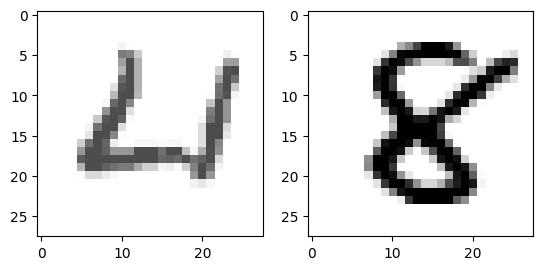

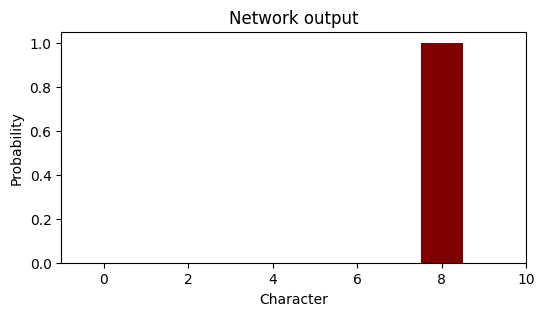

In [ ]:
PlotTest(33,3198,model_LR_FH1,0.7,1,X_test)

1/1 [==============================] - 0s 25ms/step


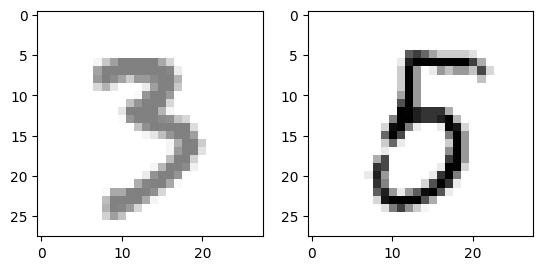

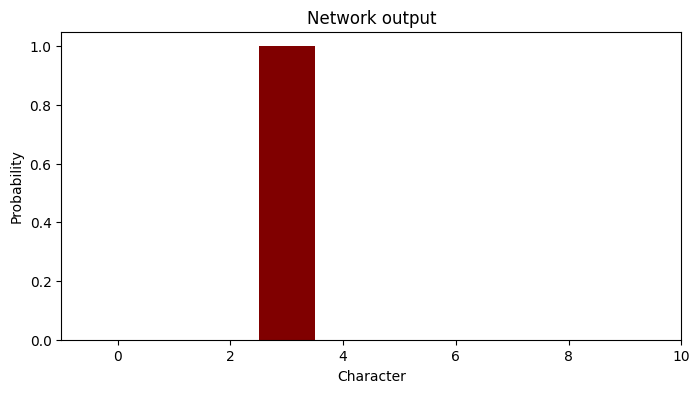

In [ ]:
XX1 = X_test[30:31]
XX2 = X_test[45:46]
A
y_predXX = model_LR_FH2.predict((0.7*XX1,0*XX2))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(0.5*XX1[0],cmap="binary",vmax=1)
ax2.imshow(XX2[0],cmap="binary",vmax=1)
#plt.axis("off")
fig = plt.figure(figsize = (8, 4))

# creating the bar plot
seq = np.array([i for i in range(10)])
plt.bar(seq,y_predXX[0], color ='maroon',width=1)

plt.xlabel("Character")
plt.ylabel("Probability")
plt.title("Network output")
plt.show()

1/1 [==============================] - 0s 31ms/step


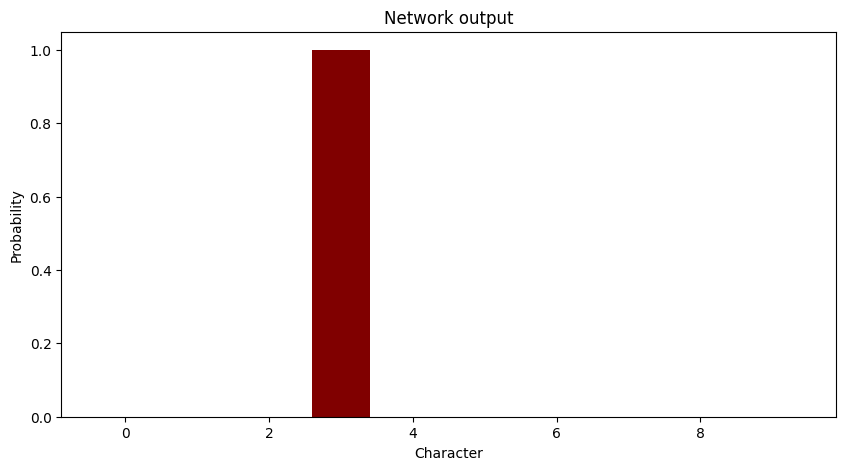

In [ ]:
y_predXX = model_LR_FH2.predict((0.7*XX1,0*XX2))
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
seq = np.array([i for i in range(10)])
plt.bar(seq,y_predXX[0], color ='maroon')

plt.xlabel("Character")
plt.ylabel("Probability")
plt.title("Network output")
plt.show()